In [1]:
!rm -r AI_USI_MA/
!git clone https://github.com/UmbertoJr/AI_USI_MA.git

rm: AI_USI_MA/: No such file or directory
Cloning into 'AI_USI_MA'...
remote: Enumerating objects: 430, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 430 (delta 67), reused 126 (delta 35), pack-reused 265
Receiving objects: 100% (430/430), 14.31 MiB | 2.68 MiB/s, done.
Resolving deltas: 100% (197/197), done.


# The Orienteering Problem with Time Windows

column of X:

0. index of the customer
1. x coordinate
2. y coordinate
3. lower time window
4. uppper time window
5. reward customer
6. global time constraint

adj is the distance matrix

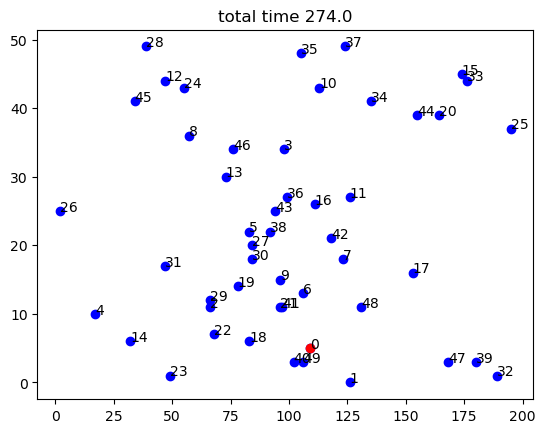

[[0.00e+00 1.09e+02 5.00e+00 0.00e+00 2.74e+02 0.00e+00 2.74e+02]
 [1.00e+00 1.26e+02 0.00e+00 2.13e+02 2.32e+02 1.70e-01 2.74e+02]
 [2.00e+00 6.60e+01 1.10e+01 2.31e+02 2.31e+02 4.00e-01 2.74e+02]
 [3.00e+00 9.80e+01 3.40e+01 1.31e+02 1.69e+02 2.90e-01 2.74e+02]
 [4.00e+00 1.70e+01 1.00e+01 1.82e+02 1.82e+02 8.40e-01 2.74e+02]]
(50, 7)
(50, 50)


In [2]:
import numpy as np
from AI_USI_MA.OPTW import Env, plot_instance

env = Env(from_file=True, instance_number=0)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

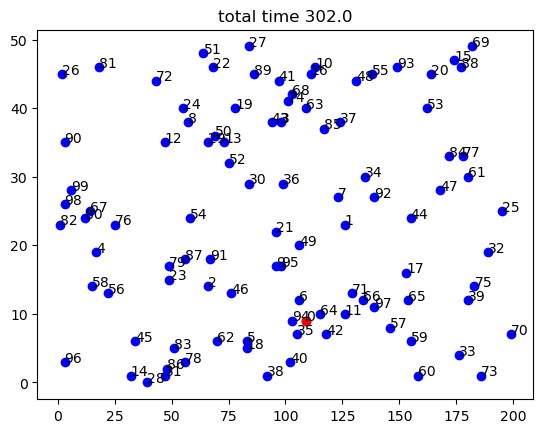

[[0.00e+00 1.09e+02 9.00e+00 0.00e+00 3.02e+02 0.00e+00 3.02e+02]
 [1.00e+00 1.26e+02 2.30e+01 2.06e+02 2.25e+02 2.00e-01 3.02e+02]
 [2.00e+00 6.60e+01 1.40e+01 4.00e+01 7.10e+01 3.80e-01 3.02e+02]
 [3.00e+00 9.80e+01 3.80e+01 1.17e+02 1.49e+02 2.80e-01 3.02e+02]
 [4.00e+00 1.70e+01 1.90e+01 2.09e+02 2.09e+02 8.20e-01 3.02e+02]]
(100, 7)
(100, 100)


In [3]:
env = Env(from_file=True, instance_number=1)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

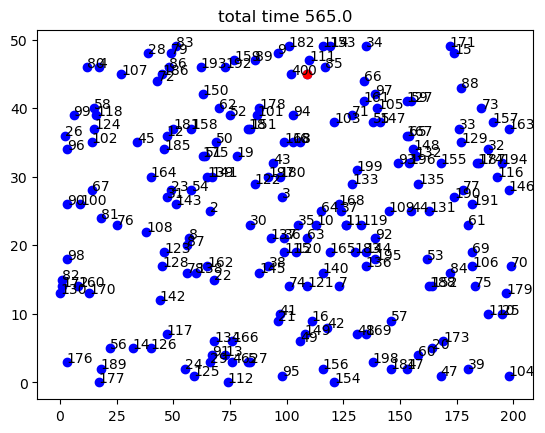

[[0.00e+00 1.09e+02 4.50e+01 0.00e+00 5.65e+02 0.00e+00 5.65e+02]
 [1.00e+00 1.26e+02 2.30e+01 1.41e+02 1.78e+02 2.50e-01 5.65e+02]
 [2.00e+00 6.60e+01 2.50e+01 5.18e+02 5.18e+02 4.10e-01 5.65e+02]
 [3.00e+00 9.80e+01 2.70e+01 2.40e+01 7.10e+01 1.90e-01 5.65e+02]
 [4.00e+00 1.70e+01 4.60e+01 4.73e+02 4.73e+02 8.00e-01 5.65e+02]]
(200, 7)
(200, 200)


In [4]:
env = Env(from_file=True, instance_number=2)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

### check if solution is feasible and print it

In [5]:
env.adj[49, 18]

39

In [6]:
X[18]

array([1.80e+01, 8.30e+01, 3.70e+01, 3.86e+02, 4.12e+02, 2.40e-01,
       5.65e+02])

time window violated 225.0 
current time  233.0 
from node 1  to  49
(233.0, 0, False)


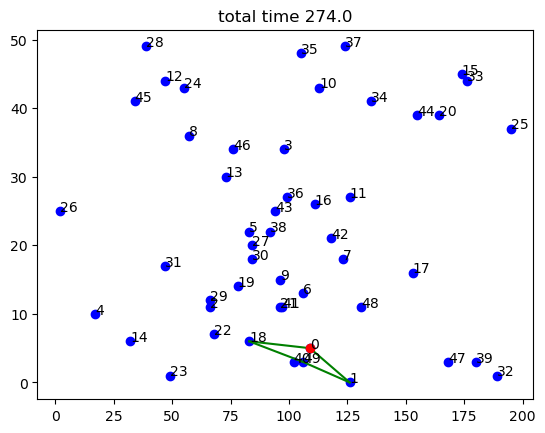

In [7]:
sol = [0, 1, 49, 18, 0]
env = Env(from_file=True, instance_number=0, verbose=True)
print(env.check_solution(sol))
plot_instance(env.x, sol)

(236.0, 0.44999999999999996, True)


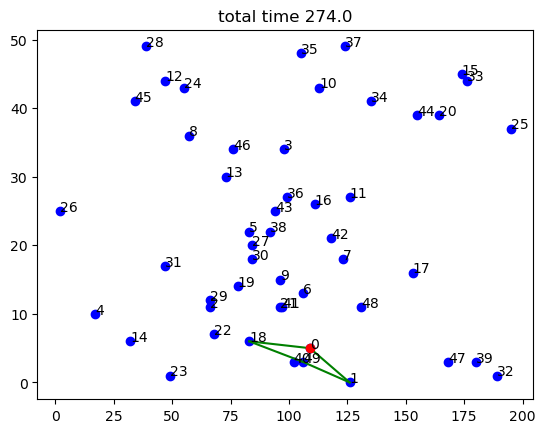

In [8]:
sol = [0, 18, 49, 1, 0]
env = Env(from_file=True, instance_number=0, verbose=True)
print(env.check_solution(sol))
plot_instance(env.x, sol)

# Monte Carlo Tree Search

### Node class for the Tree Search


In [9]:
### Node Object ###
class Node:
    def __init__(self, parent, node, travel_time, partial_path, current_reward, expandable_customers):
      self.parent = parent                                                      # parent node object
      self.node = node                                                          # current node (or customer) index
      self.partial_path = partial_path                                          # current partial path across customers
      self.current_reward = current_reward                                      # current reward collected in the partial path
      self.num_of_visit = 0                                                     # number of visit to the current node during the MCTS
      self.terminal = False                                                     # boolean to determine if node is terminal
      self.fully_expanded = False                                               # boolean to determine if node was expanded completely during the search
      self.estimated_reward = 0                                                 # esteem of the future reward collected thanks to the MC simulations
      self.travel_time = travel_time                                            # travel time spent with the current partial path
      self.score = None                                                         # Upper Confidence Buond score for node
      self.policy = None                                                        # IMPORTANT !!!!! Best node index according to the UCB score
      self.expandables = copy.deepcopy(expandable_customers)                    # customers in the candidate list of the current node that are not in the current path
      self.expanded = {}                                                        # nodes already expanded during the search
      if len(self.expandables) == 0:
        self.fully_expanded = True
        self.terminal = True
        self.partial_path.append(0)
        self.policy = 0

    def calculateUCTscore(self, best_reward_so_far):
      # computes the Upper Confidence Bound for the Node
      c=1/(2**0.5)
      self.score = (((self.estimated_reward/ self.num_of_visit) + self.current_reward) /
                    best_reward_so_far) + c * 2 * (2 * np.log(self.parent.num_of_visit) /
                                                   self.num_of_visit) ** 0.5


### MCTS

In [10]:
from time import time
import copy
import numpy as np
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')


class MCTS:
  def __init__(self, env,time_limit, initial_path):
    self.num_of_customers = env.n_nodes                                         # number of customers in the current problem
    self.env = env                                                              # environment of the problem to solve
    self.time_limit = time_limit                                                # time budget for the OPTW to solve
    self.initial_path = initial_path                                            # initial path
    self.root_node = initial_path[-1]                                           # root node index

    # saving the best tour so far, its reward and time travel
    self.best_tour_so_far = initial_path + [0]
    travel_time, self.max_reward, _ = self.env.check_solution(self.best_tour_so_far)

    # these operations find the promising CL for the root node
    ordered_view = {i: self.env.x[i, 5]/(self.env.x[i, 3] / self.env.x[i, 6]) for i in range(1, self.num_of_customers) if i not in initial_path
                    and self.env.adj[self.root_node, i] + travel_time < self.env.x[i, 4]
                    and self.env.adj[i, 0] + self.env.adj[self.root_node, i] + travel_time < self.env.x[i, 6]}
    ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: item[1]) if k not in initial_path]

    # initialize the root node
    self.root = Node(parent=None,
                     node= self.root_node,
                     travel_time =travel_time,
                     partial_path=initial_path,
                     current_reward=0,
                     expandable_customers = ordered_list)


  def treePolicy(self, node):
    """
    This function expand a node if the selected node is not being completely expanded,
    otherwise it select the best child in the Tree using the selectBestChild function
    """
    # TO DO
    while not node.terminal:
      if not node.fully_expanded:
        node = self.expand(node)
      else:
        node = self.selectBestChild(node)
    return node



  def selectBestChild(self, node):
    """
    The function updates the UBC score for each child node by employing the updated max_reward
    then it returns the best child according to such score.
    """
    best_score = 0
    best_score = 0
        # TO DO

    best_child = None
    best_child = None
    best_reward_so_far = 0

    for child_key, child_node in node.expanded.items():
      current_reward = child_node.current_reward

      if best_reward_so_far < current_reward:
        best_reward_so_far = current_reward

      child_node.calculateUCTscore(best_reward_so_far)
      new_score = child_node.score

      if best_score < new_score:
        best_score = new_score
        best_child = child_node
        node.policy = child_key

    return best_child


  def expand(self, node):
    new_node = node.expandables.pop()                                           # it selects the most promising node from the CL
    new_path = copy.deepcopy(node.partial_path)                                 # it copies the path and append new node to it
    new_path.append(new_node)

    new_reward = node.current_reward                                            # update of the reward for the new customer
    new_reward += self.env.x[new_node, 5]

    new_travel_time = max(node.travel_time + self.env.adj[node.node, new_node], # updated the travel time
                          self.env.x[new_node, 3])

    # these operations find the promising CL for the root node
    ordered_view = {i: self.env.x[i, 5]/(self.env.x[i, 3] / self.env.x[i, 6]) for i in range(1, self.num_of_customers) if i not in new_path
                    and self.env.adj[new_node, i] + new_travel_time < self.env.x[i, 4]
                    and self.env.adj[i, 0] + self.env.adj[new_node, i] + new_travel_time < self.env.x[i, 6]}
    ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: item[1]) if k not in new_path]

    new_node_object = Node(parent=node,
                           node=new_node,
                           travel_time=new_travel_time,
                           partial_path=new_path,
                           current_reward=new_reward,
                           expandable_customers=ordered_list)

    node.expanded[new_node] = new_node_object
    if len(node.expandables) == 0:
      node.fully_expanded = True

    if new_node == 0:
      new_node_object.terminal = True
      _, new_r, _ = self.env.check_solution(new_path)
      if new_r > self.max_reward:
        self.max_reward = new_r
        self.best_tour_so_far = new_path

    return new_node_object

  def defaultPolicy(self, starting_node):
    # reach the end, break condition
    if starting_node.node == 0:
      return 0

    customer = starting_node.node
    new_path = starting_node.partial_path
    travel_time = starting_node.travel_time
    while customer != 0:
      # these operations find the promising CL for the root node
      ordered_view = {i: (self.env.x[i, 5] + np.finfo(float).eps)/(self.env.x[i, 3] / self.env.x[i, 6] + np.finfo(float).eps ) for i in range(1, self.num_of_customers) if i not in new_path
                      and self.env.adj[customer, i] + travel_time < self.env.x[i, 4]
                      and self.env.adj[i, 0] + self.env.adj[customer, i] + travel_time < self.env.x[i, 6]}
      ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: -item[1]) if k not in new_path]
      if len(ordered_list) == 0:
        customer = 0
      else:
        probabilities = softmax(np.array([v for k, v in sorted(ordered_view.items(), key=lambda item: -item[1]) if k not in new_path]))
        customer = int(np.random.choice(ordered_list, 1, p=probabilities))

      new_path.append(customer)
      travel_time = max(travel_time + self.env.adj[new_path[-2], customer], self.env.x[customer, 3])

    _, new_r, _ = self.env.check_solution(new_path)
    if new_r > self.max_reward:
        self.max_reward = new_r
        self.best_tour_so_far = new_path

    return new_r - starting_node.current_reward


  def backup(self, node, reward_esteem):
    """
    backup of the estimated reward in the MCTS
    """
    # TO DO
    while node is not None:
      node.num_of_visit += 1
      node.estimated_reward += reward_esteem
      node = node.parent
    pass

  def step(self, num_of_simulation=1):
    start = time()
    while time() - start < self.time_limit:
        current_node = self.treePolicy(self.root)
        reward_esteem = self.defaultPolicy(current_node)
        self.backup(current_node, reward_esteem)

    return self.root.policy if self.root.policy != None else 0

(274.0, 0.84, True)


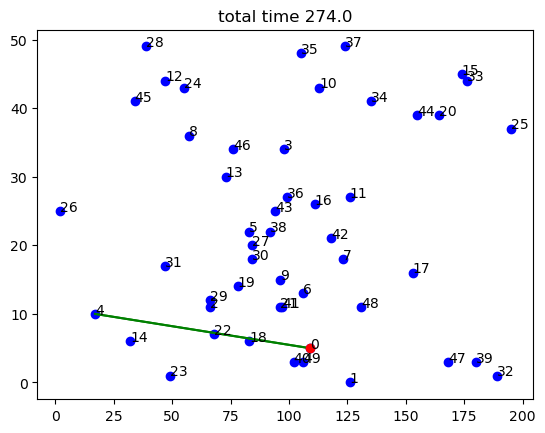

(274.0, 3.2199999999999998, True)


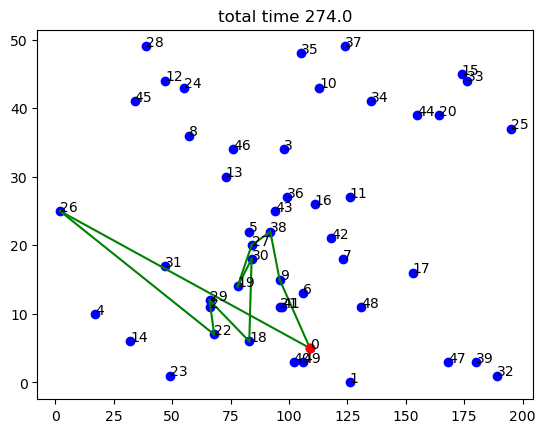

In [11]:
env = Env(from_file=True, instance_number=0)
time_limit = 5
sol = [0]
best_sol = None
best_r = 0
while True:
  mcts = MCTS(env, time_limit, sol)
  mcts.best_tour_so_far = best_sol
  mcts.max_reward = best_r
  new_customer = mcts.step()
  # print("a new customer is", new_customer)
  sol.append(new_customer)
  if mcts.max_reward > best_r:
    best_r = mcts.max_reward
    best_sol = mcts.best_tour_so_far
  if sol[-1] == 0:
    break


print(env.check_solution(sol))
plot_instance(env.x, sol)
print(env.check_solution(best_sol))
plot_instance(env.x, best_sol)

(302.0, 0.65, True)


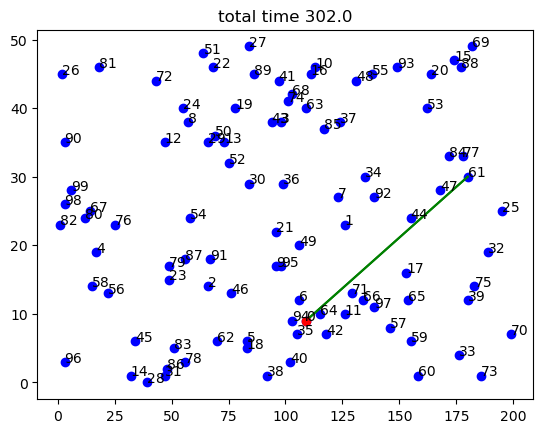

(302.0, 2.42, True)


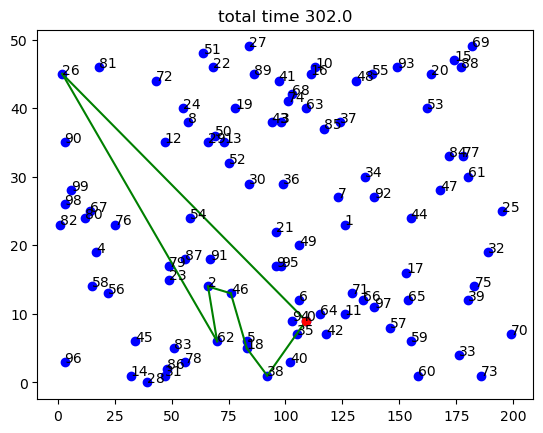

In [12]:
env = Env(from_file=True, instance_number=1)
time_limit = 5
sol = [0]
best_sol = None
best_r = 0
while True:
  mcts = MCTS(env, time_limit, sol)
  mcts.best_tour_so_far = best_sol
  mcts.max_reward = best_r
  new_customer = mcts.step()
  # print("a new customer is", new_customer)
  sol.append(new_customer)
  if mcts.max_reward > best_r:
    best_r = mcts.max_reward
    best_sol = mcts.best_tour_so_far
  if sol[-1] == 0:
    break

print(env.check_solution(sol))
plot_instance(env.x, sol)
print(env.check_solution(best_sol))
plot_instance(env.x, best_sol)

(565.0, 0.07, True)


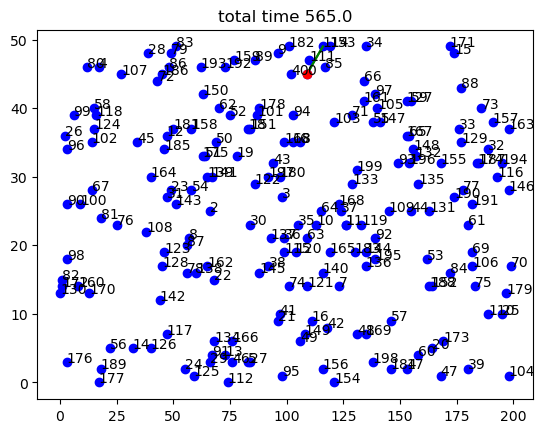

(565.0, 5.03, True)


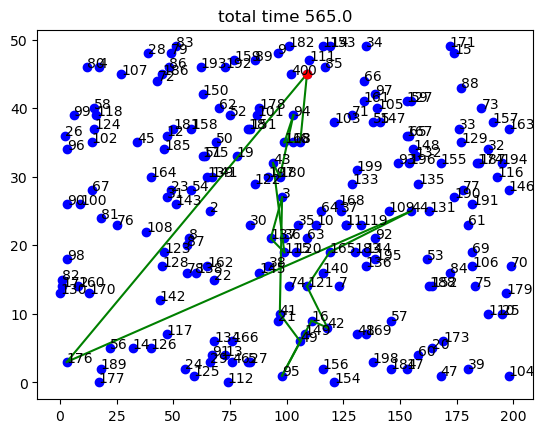

In [13]:
env = Env(from_file=True, instance_number=2)
time_limit = 5
sol = [0]
best_sol = None
best_r = 0
while True:
  mcts = MCTS(env, time_limit, sol)
  mcts.best_tour_so_far = best_sol
  mcts.max_reward = best_r
  new_customer = mcts.step()
  sol.append(new_customer)
  if mcts.max_reward > best_r:
    best_r = mcts.max_reward
    best_sol = mcts.best_tour_so_far
  if sol[-1] == 0:
    break

print(env.check_solution(sol))
plot_instance(env.x, sol)
print(env.check_solution(best_sol))
plot_instance(env.x, best_sol)

The **_treePolicy_** function helps us decide whether to expand a node or choose the best child of the node. During this process, we go through the nodes. As long as we haven't reached a final node, we check if the node is fully expanded. If it is, we expand the node; otherwise, we choose the best child of the node.

The **_selectBestChild_** function is responsible for choosing the best child of a given node. To determine this, we calculate the Upper Confidence Bounds for Trees (UCT) to update the score. After updating the scores for all the node's children, we select the child with the highest score as the best child. This function uses the calculateUCTscore function to compute the new score. To do this, we need to provide the best reward encountered so far. In this context, we consider the best reward so far as the highest reward the program has observed up to that point.

The **_backup_** function is responsible for updating certain parameters of a node. Specifically, it increments the number of visits that the current node has received by one. Additionally, it updates the estimated reward for the node and replaces the current node with its parent in the process.